In [107]:
#Import libraries
import requests
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.10.0


In [108]:
LEARNING_RATE = 0.00033 
EPOCH = 1100
BATCH_SIZE = 8

In [109]:
#GRAIN_TYPE = 'Wheat'
GRAIN_TYPE = 'Combined_Grains'
FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + 'classifyVariety.h5'
URL = "../../Datasets/processed/" + GRAIN_TYPE + ".csv"
df = pd.read_csv(URL)
# Convert to numpy array
#df = df.groupby('Variety').head(120)
df_features = df[[ 
                    'Freq', 
                    'd(cm)', 
             #       'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    ]]

df_targets = df[['Grain Type']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
scaler = StandardScaler()
dataset_x = scaler.fit_transform(dataset_x)
dataset_y = df_targets.to_numpy()

In [110]:
from sklearn.preprocessing import LabelEncoder

# Getting the number of unique varieties
num_varieties = df_targets['Grain Type'].nunique()
varieties = df_targets['Grain Type'].unique()
print(f'There are {num_varieties} different grain types.')

# Encode the 'variety' labels
label_encoder = LabelEncoder()
# Step 1: Convert varieties into number ex. 1 2 3... and store in a single list
integer_encoded = label_encoder.fit_transform(df_targets['Grain Type'])
# Step 2: Get the number of different classes
depth = num_varieties
# Step 3: Pass in the list of numerical values and the number of classes and vectors are created 
#         For example the value 4 would be passed and converted to [0. 0. 0. 0. 1.]
one_hot_encoded = tf.one_hot(integer_encoded, depth)
# Step 4: Convert to numpy arr
y_one_hot = one_hot_encoded.numpy()  # If using TensorFlow's one_hot


There are 5 different grain types.


In [111]:
'''
Uncomment this to have the dataset split be uniform in test set but not train set, no val included.
'''

# from sklearn.model_selection import train_test_split
# import tensorflow as tf

# # Assume other parts of the code (dataset_x, y_integers, depth) are defined as in previous examples

# # Perform stratified train-test split on the data to maintain class distribution
# X_train, X_temp, y_train_integer, y_temp_integer = train_test_split(
#     dataset_x, integer_encoded, test_size=0.20, stratify=integer_encoded, random_state=42
# )
# # Convert the integer labels back to one-hot encoding for TensorFlow/Keras for the training set
# y_train = tf.one_hot(y_train_integer, depth).numpy()

# # Now create a balanced test set from X_temp and y_temp_integer
# unique_classes = np.unique(y_train_integer)
# samples_per_class = min(np.bincount(y_temp_integer))  # Find the smallest class size in the test set

# # Create a list to store the sampled indices
# indices_to_keep = []

# for cls in unique_classes:
#     # Get the indices for each class
#     class_indices = np.where(y_temp_integer == cls)[0]
#     # Randomly choose 'samples_per_class' indices from each class
#     chosen_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)
#     indices_to_keep.extend(chosen_indices)

# # Use the indices to create the balanced test set
# X_test = X_temp[indices_to_keep]
# y_test_integer = y_temp_integer[indices_to_keep]

# # Convert the integer labels back to one-hot encoding for TensorFlow/Keras for the test set
# y_test = tf.one_hot(y_test_integer, depth).numpy()


'\nUncomment this to have the dataset split be uniform in test set but not train set, no val included.\n'

In [112]:

unique, counts = np.unique(integer_encoded, return_counts=True)
min_class_size = min(counts)
print(f"Minimum class size: {min_class_size}")

# Calculate the number of samples for each class in the train and test sets
# Here we are assuming an 80-20 split, adjust these values as necessary
train_samples_per_class = int(min_class_size * 0.8)
test_samples_per_class = int(min_class_size - train_samples_per_class - min_class_size * 0.15)
val_samples_per_class = int(min_class_size - train_samples_per_class - min_class_size * 0.15)
# Initialize lists to store the training and test indices
train_indices = []
test_indices = []
val_indices = []
# Sample indices for the train and test sets
for cls in unique:
    # Get the indices for each class
    class_indices = np.where(integer_encoded == cls)[0]
    
    # Shuffle class indices to randomize selection
    np.random.shuffle(class_indices)
    
    # Split class indices into train and test samples
    train_indices.extend(class_indices[:train_samples_per_class])
    test_indices.extend(class_indices[train_samples_per_class:train_samples_per_class + test_samples_per_class])
    val_indices.extend(class_indices[train_samples_per_class:train_samples_per_class + test_samples_per_class + val_samples_per_class])
# Shuffle the train and test indices to mix the classes
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

# Create the balanced train and test sets
X_train = dataset_x[train_indices]
y_train_integer = integer_encoded[train_indices]
X_test = dataset_x[test_indices]
y_test_integer = integer_encoded[test_indices]
y_val_integer = integer_encoded[val_indices]
# Convert the integer labels back to one-hot encoding for TensorFlow/Keras
y_train = tf.one_hot(y_train_integer, depth).numpy()
y_test = tf.one_hot(y_test_integer, depth).numpy()
y_val = tf.one_hot(y_val_integer, depth).numpy()

Minimum class size: 366


In [113]:
y_train_binary = np.where(y_train_integer == label_encoder.transform(['Wheat'])[0], 1, 0)
y_test_binary = np.where(y_test_integer == label_encoder.transform(['Wheat'])[0], 1, 0)

In [114]:
def print_dataset_split(y_train_integer,y_test_integer):
    # Create a DataFrame for the training set class distribution
    train_counts = pd.DataFrame({
        'Class Name': label_encoder.inverse_transform(np.unique(y_train_integer)),
        'Train': np.bincount(y_train_integer)
    })

    # Create a DataFrame for the balanced test set class distribution
    test_counts = pd.DataFrame({
        'Class Name': label_encoder.inverse_transform(np.unique(y_test_integer)),
        'Test': np.bincount(y_test_integer)
    })
    # val_counts = pd.DataFrame({
    #     'Class Name': label_encoder.inverse_transform(np.unique(y_val_integer)),
    #     'Val': np.bincount(y_val_integer)
    # })
    # Merge the two DataFrames on Class Name
    acombined_counts = pd.merge(train_counts, test_counts, on='Class Name', how='outer').fillna(0)
    # acombined_counts = pd.merge(combined_counts, val_counts, on='Class Name', how='outer').fillna(0)
    # Converts to integer type
    acombined_counts['Train'] = acombined_counts['Train'].astype(int)
    acombined_counts['Test'] = acombined_counts['Test'].astype(int)
    # acombined_counts['Val'] = acombined_counts['Val'].astype(int)

    # Set display options for pandas
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.colheader_justify', 'center')
    pd.set_option('display.precision', 3)

    # Print combined class counts in a tabular format
    print(acombined_counts.to_string(index=False, justify='right'))
print_dataset_split(y_train_integer,y_test_integer)

Class Name  Train  Test
    Barley    292    19
      Corn    292    19
      Oats    292    19
   Sorghum    292    19
     Wheat    292    19


In [115]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define model
model = tf.keras.Sequential([
    Dense(256, activation='relu'),
    
    Dense(256, activation='relu'),
    
    Dense(256, activation='relu'),
    
    Dense(1, activation='sigmoid')  # Changed to softmax for multi-class
])


model.compile(
    loss='binary_crossentropy',  # Changed to binary_crossentropy for binary classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model.fit(X_train, y_train_binary, epochs=EPOCH, batch_size=BATCH_SIZE)
model.save(FILENAME_BEST_MODEL)

Epoch 1/1100
183/183 [==============================] - 0s 564us/step - loss: 0.4428 - accuracy: 0.7973 - precision_7: 0.1667 - recall_7: 0.0034
Epoch 2/1100
183/183 [==============================] - 0s 520us/step - loss: 0.4081 - accuracy: 0.8000 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 3/1100
183/183 [==============================] - 0s 513us/step - loss: 0.3937 - accuracy: 0.7986 - precision_7: 0.2500 - recall_7: 0.0034  
Epoch 4/1100
183/183 [==============================] - 0s 514us/step - loss: 0.3764 - accuracy: 0.8014 - precision_7: 0.6250 - recall_7: 0.0171  
Epoch 5/1100
183/183 [==============================] - 0s 517us/step - loss: 0.3674 - accuracy: 0.7966 - precision_7: 0.4658 - recall_7: 0.1164
Epoch 6/1100
183/183 [==============================] - 0s 548us/step - loss: 0.3529 - accuracy: 0.7952 - precision_7: 0.4462 - recall_7: 0.0993 
Epoch 7/1100
183/183 [==============================] - 0s 543us/step - loss: 0.3389 - accuracy: 0.7952 - precision_7

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import numpy as np

num_classes = 2  # Update this with the actual number of classes you have
class_names = ['Non-wheat', 'Wheat']

def compute_confusion_matrix(true, pred):
    conf_mat = confusion_matrix(true, pred)
    print("       Actual")
    print("       0   1")
    print("pred 0", end=" ")
    for item in conf_mat[0]:
        print("{:^3}".format(item), end=" ")
    print()
    print("     1", end=" ")
    for item in conf_mat[1]:
        print("{:^3}".format(item), end=" ")
    print()

def compute_metrics_per_class(true, pred):
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    accuracy = accuracy_score(true, pred)

    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"Accuracy: {accuracy:.3f}")

y_pred_labels = np.round(model.predict(X_test)).flatten().astype(int)
y_test_binary_list = y_test_binary.tolist()

print_dataset_split(y_train_integer, y_test_integer)
print()
print("=================================================================")
compute_confusion_matrix(y_test_binary_list, y_pred_labels.tolist())
print()
print("=================================================================")
compute_metrics_per_class(y_test_binary_list, y_pred_labels.tolist())
print("HYPERPARAMS: LR:", LEARNING_RATE, " EPOCH:", EPOCH, " BATCH:", BATCH_SIZE)
print("<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>")

3/3 [==============================] - 0s 659us/step


Class Name  Train  Test
    Barley    292    19
      Corn    292    19
      Oats    292    19
   Sorghum    292    19
     Wheat    292    19

       Actual
       0   1
pred 0 71   5  
     1  2  17  

Precision: 0.773
Recall: 0.895
Accuracy: 0.926
HYPERPARAMS: LR: 0.00033  EPOCH: 1100  BATCH: 16
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>


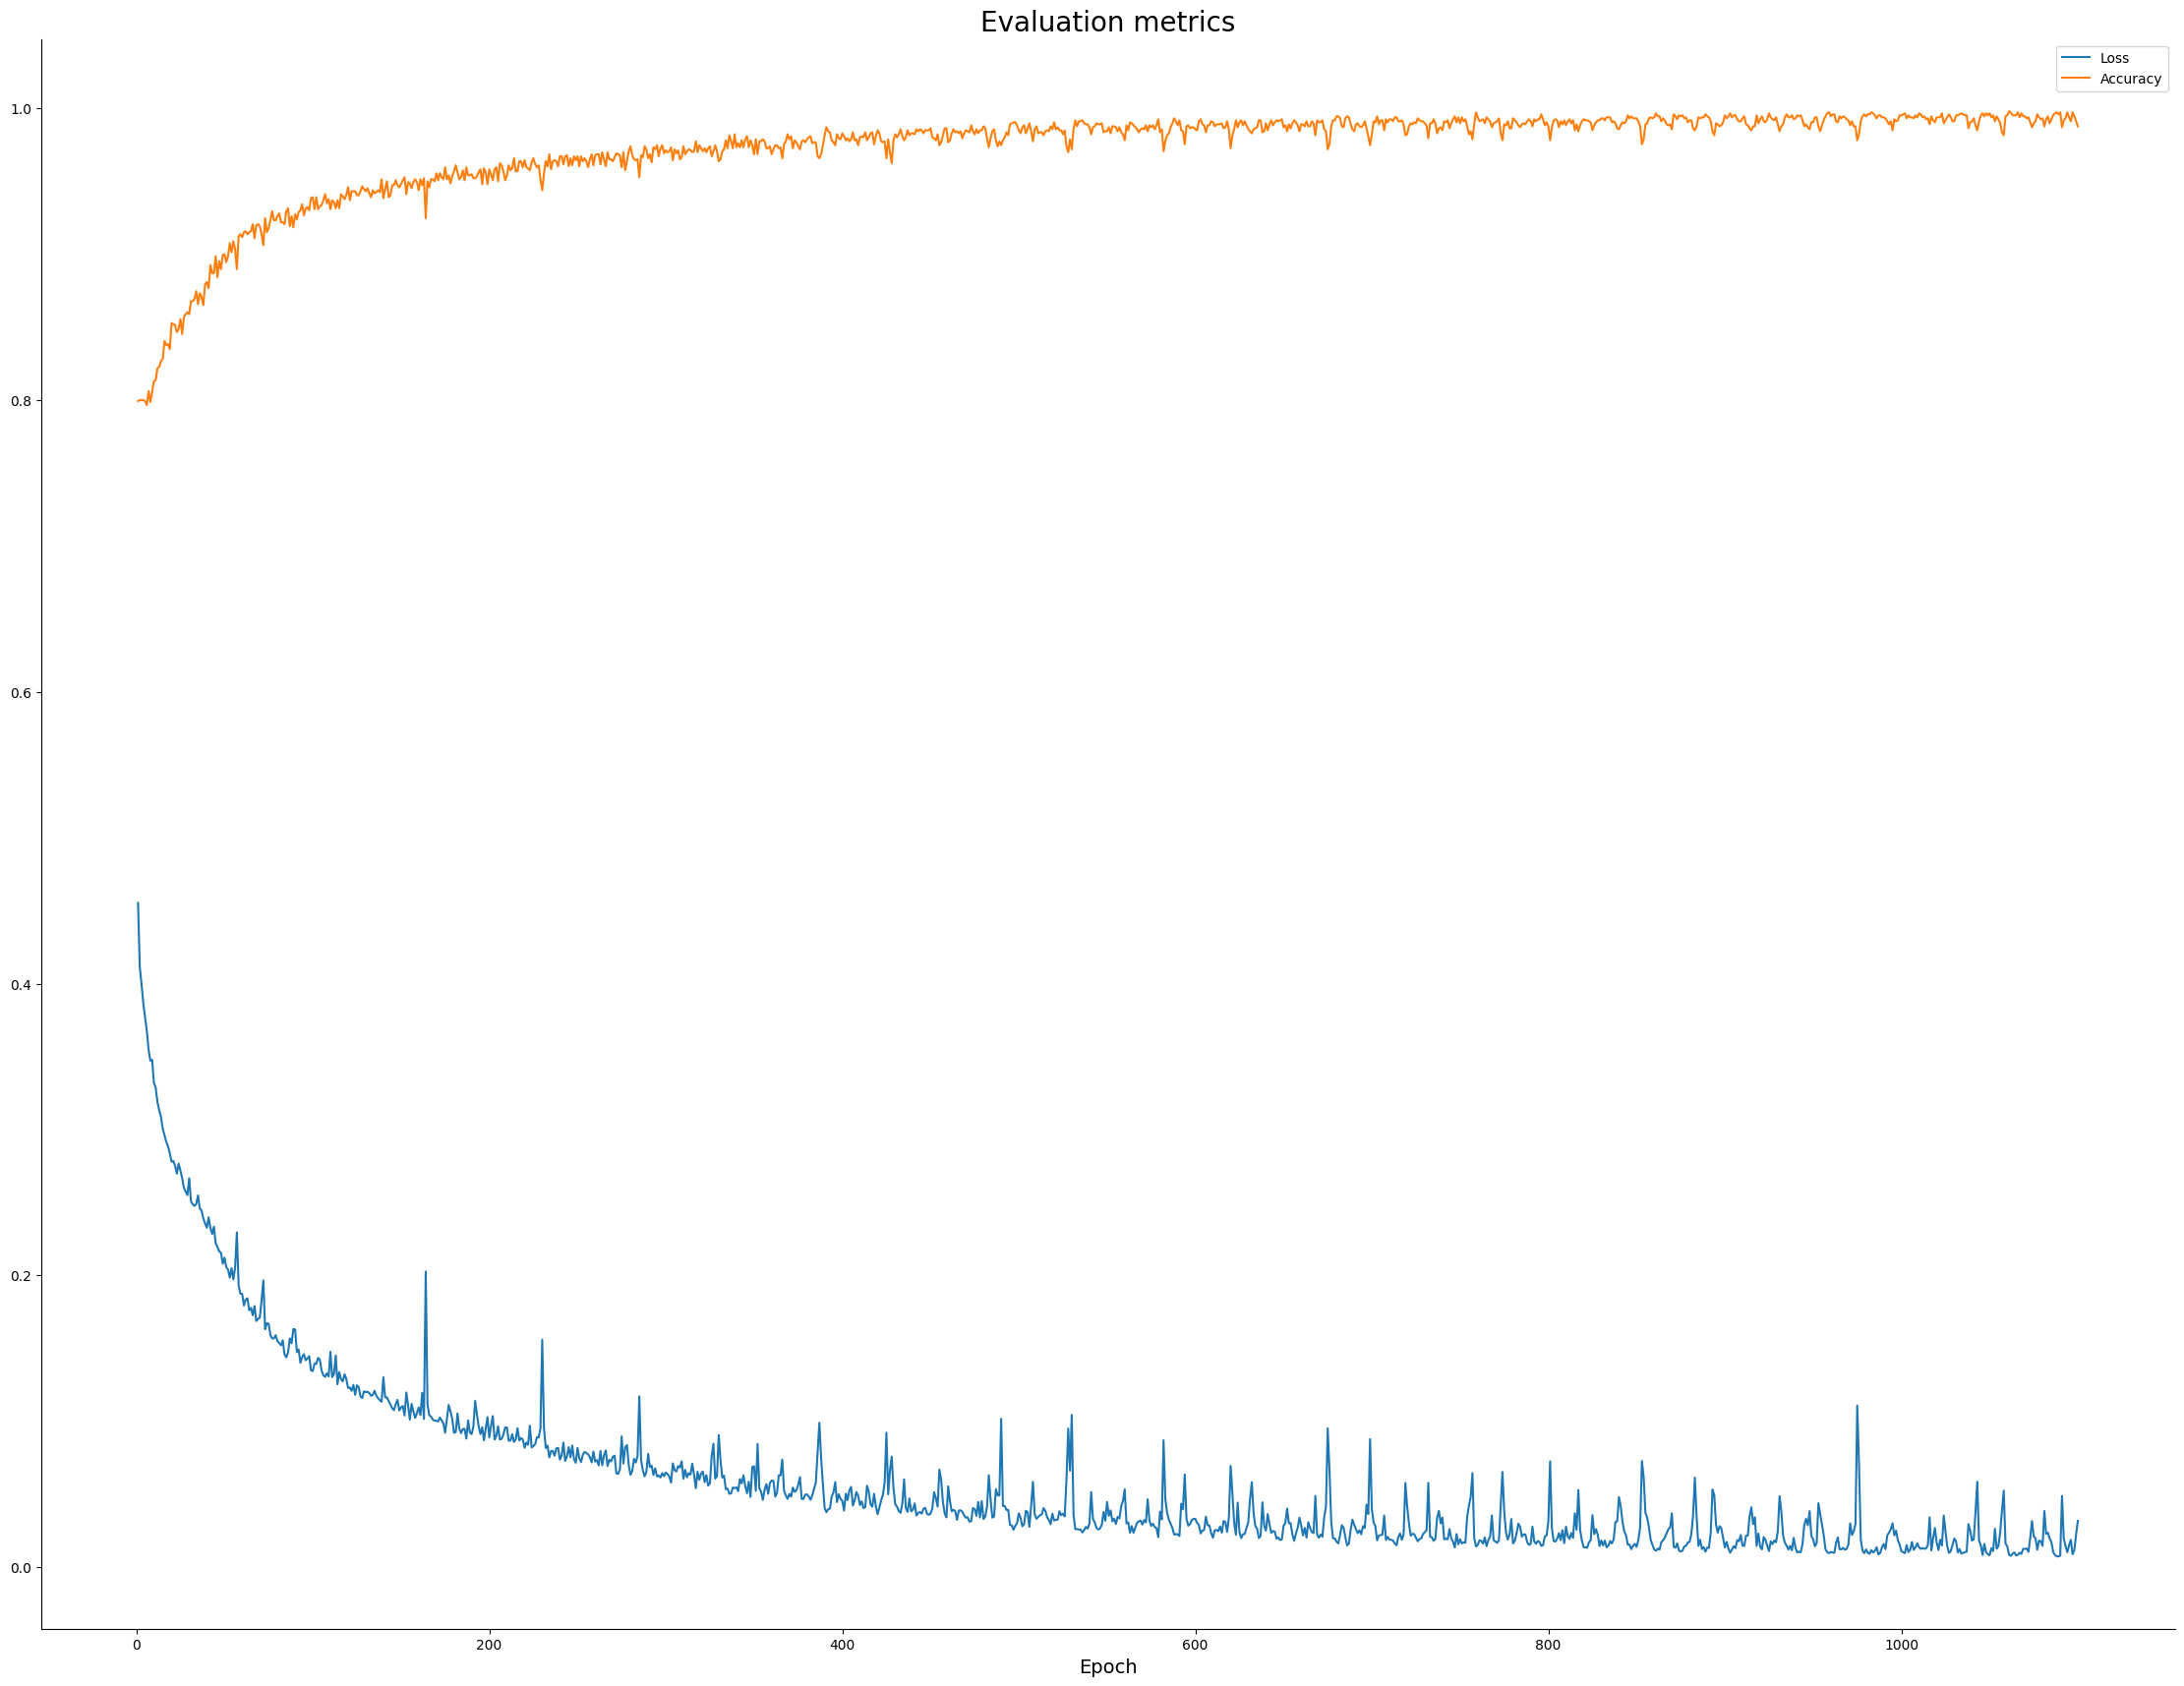

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
trial_timeout=30
rcParams['figure.figsize'] = (28, 21)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

# Correcting the range of epochs to match the actual number of epochs trained
epochs_trained = len(history.history['loss']) 

# Plot Loss and Accuracy
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['accuracy'], label='Accuracy'
)

# Plot Precision and Recall for each class
num_classes = 5  # Update this with the actual number of classes you have
for i in range(num_classes):
    precision_label = f'precision_class_{i}'
    recall_label = f'recall_class_{i}'
    
    # Check if precision and recall for each class are in history to avoid KeyError
    if precision_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[precision_label], label=f'Precision Class {i}'
        )
    if recall_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[recall_label], label=f'Recall Class {i}'
        )

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()
